# Sistema de Recomendación de Libros

Este proyecto implementa un sistema de recomendación de libros utilizando la biblioteca `scikit-surprise`. El objetivo es predecir la calificación que un usuario daría a un libro que no ha calificado aún y recomendar los libros con las calificaciones predichas más altas.


## Librerías Utilizadas

- `isbnlib`: Utilizada para validar y trabajar con números ISBN.
- `pandas`: Usada para la manipulación y análisis de datos.
- `matplotlib.pyplot` y `seaborn`: Para visualizaciones y gráficos.
- `surprise`: Implementa algoritmos para sistemas de recomendación.
- `scikit-surprise`: Otra biblioteca para sistemas de recomendación y modelado colaborativo.
- `sklearn.model_selection`: Usado para dividir datos en conjuntos de entrenamiento y prueba.

In [1]:
pip install isbnlib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import isbnlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from sklearn.model_selection import train_test_split

# Carga de Datos

Aquí, cargamos los conjuntos de datos para verificar la preparaciones necesarias.


In [3]:
# Carga de datos
usuarios = pd.read_csv('Users.csv')
libros = pd.read_csv('Books.csv', low_memory=False)
calificaciones = pd.read_csv('Ratings.csv')

print("Dataset 'libros':")
print("Columnas:", libros.columns.tolist())
print("Número total de registros:", len(libros))
print("5 ejemplos:")
print(libros.head(5))
print("\n")

print("Dataset 'calificaciones':")
print("Columnas:", calificaciones.columns.tolist())
print("Número total de registros:", len(calificaciones))
print("5 ejemplos:")
print(calificaciones.head(5))
print("\n")

print("Dataset 'usuarios':")
print("Columnas:", usuarios.columns.tolist())
print("Número total de registros:", len(usuarios))
print("5 ejemplos:")
print(usuarios.head(5))
print("\n")

Dataset 'libros':
Columnas: ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']
Número total de registros: 271360
5 ejemplos:
         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber

# Preprocesamiento de Datos

Aquí realizamos el preprocesamiento necesario para preparar los datos para el modelado. Esto incluye la limpieza de datos, manejo de valores nulos, y transformaciones necesarias.

In [4]:
# Preprocesamiento básico

# Convertir Year-Of-Publication a numérico y manejar valores inválidos
libros['Year-Of-Publication'] = pd.to_numeric(libros['Year-Of-Publication'], errors='coerce')
libros['Year-Of-Publication'].fillna(libros['Year-Of-Publication'].mean(), inplace=True)
libros['Year-Of-Publication'] = libros['Year-Of-Publication'].astype(int)

# Eliminar URLs de imágenes si no son necesarias
libros.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], inplace=True)

# Normalización de los títulos de los libros
libros['Book-Title'] = libros['Book-Title'].str.lower()

# Asegurarse de que las calificaciones son numéricas
calificaciones['Book-Rating'] = pd.to_numeric(calificaciones['Book-Rating'], errors='coerce')
calificaciones.dropna(subset=['Book-Rating'], inplace=True)

# Convertir 'Age' a numérico y manejar valores inválidos o atípicos
usuarios['Age'] = pd.to_numeric(usuarios['Age'], errors='coerce')
usuarios['Age'].fillna(usuarios['Age'].mean(), inplace=True)
usuarios['Age'] = usuarios['Age'].clip(lower=0, upper=100)

# Análisis Exploratorio de Datos (EDA)


Realizamos un análisis exploratorio para entender mejor los datos.

## 1. Estadísticas Descriptivas

In [5]:
# Estadísticas descriptivas para columnas numéricas
print(libros.describe())

# Frecuencia de publicadores
print(libros['Publisher'].value_counts())

       Year-Of-Publication
count        271360.000000
mean           1959.760809
std             257.992800
min               0.000000
25%            1989.000000
50%            1995.000000
75%            2000.000000
max            2050.000000
Publisher
Harlequin                  7535
Silhouette                 4220
Pocket                     3905
Ballantine Books           3783
Bantam Books               3646
                           ... 
Hannover House                1
Amber Quill Press, LLC.       1
Lunchbox Press                1
Ugly Town                     1
Connaught                     1
Name: count, Length: 16807, dtype: int64


## 2. Análisis de 'Year-Of-Publication'

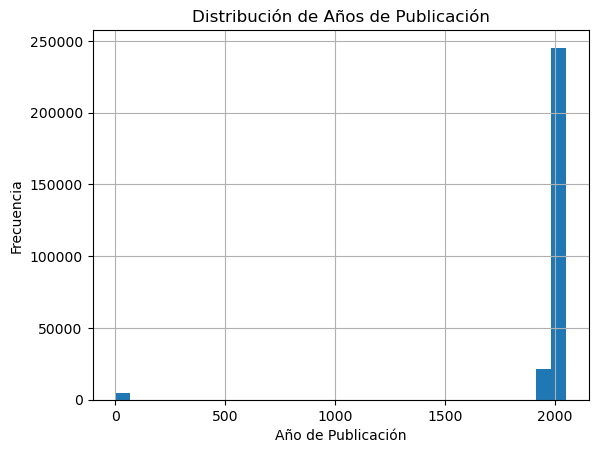

Valores atípicos en años de publicación:
              ISBN                                         Book-Title  \
37487   0671746103  my teacher fried my brains (rack size) (my tea...   
55676   0671791990  my teacher flunked the planet (rack size) (my ...   
78168   0870449842                                   crossing america   
80264   0140301690  alice's adventures in wonderland and through t...   
97826   0140201092      outline of european architecture (pelican s.)   
116053  0394701658                       three plays of eugene oneill   
118294  3442436893        das groã?â?e bã?â¶se- mã?â¤dchen- lesebuch.   
192993  0870446924  field guide to the birds of north america, 3rd...   
228173  0671266500       forest people (touchstone books (hardcover))   
240169  0684718022            in our time: stories (scribner classic)   
246842  0380000059                                              clout   
255409  068471809X                               to have and have not   
260974  06

In [6]:
# Convertir 'Year-Of-Publication' a numérico y manejar errores
libros['Year-Of-Publication'] = pd.to_numeric(libros['Year-Of-Publication'], errors='coerce')

# Rellenar los valores NaN resultantes con la media o mediana
libros['Year-Of-Publication'].fillna(libros['Year-Of-Publication'].median(), inplace=True)

# Histograma para 'Year-Of-Publication'
libros['Year-Of-Publication'].hist(bins=30)
plt.title('Distribución de Años de Publicación')
plt.xlabel('Año de Publicación')
plt.ylabel('Frecuencia')
plt.show()

# Identificar valores atípicos en 'Year-Of-Publication'
print("Valores atípicos en años de publicación:")
print(libros[libros['Year-Of-Publication'] > 2023])  # Asumiendo que el año actual es 2023

## 3. Análisis de Autores

In [7]:
# Autores con la mayor cantidad de libros publicados
autores_top = libros['Book-Author'].value_counts().head(10)
print("Autores con más libros publicados:")
print(autores_top)

Autores con más libros publicados:
Book-Author
Agatha Christie        632
William Shakespeare    567
Stephen King           524
Ann M. Martin          423
Carolyn Keene          373
Francine Pascal        372
Isaac Asimov           330
Nora Roberts           315
Barbara Cartland       307
Charles Dickens        302
Name: count, dtype: int64


## 4. Análisis de Títulos de Libros

count    271360.000000
mean         37.831169
std          25.211278
min           1.000000
25%          18.000000
50%          32.000000
75%          51.000000
max         256.000000
Name: Titulo_Longitud, dtype: float64


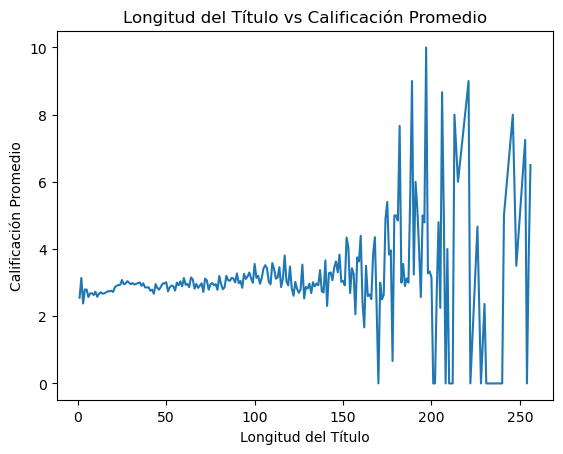

In [8]:
# Longitud de los títulos de los libros
libros['Titulo_Longitud'] = libros['Book-Title'].apply(len)

# Estadísticas descriptivas de la longitud de los títulos
print(libros['Titulo_Longitud'].describe())

# Relación entre longitud del título y calificaciones
libros_calificaciones = pd.merge(libros, calificaciones, on='ISBN')
libros_calificaciones.groupby('Titulo_Longitud')['Book-Rating'].mean().plot()
plt.title('Longitud del Título vs Calificación Promedio')
plt.xlabel('Longitud del Título')
plt.ylabel('Calificación Promedio')
plt.show()

## Relaciones entre Libros y Calificaciones
Investigamos si hay algún patrón visible entre el año de publicación de los libros y las calificaciones promedio.

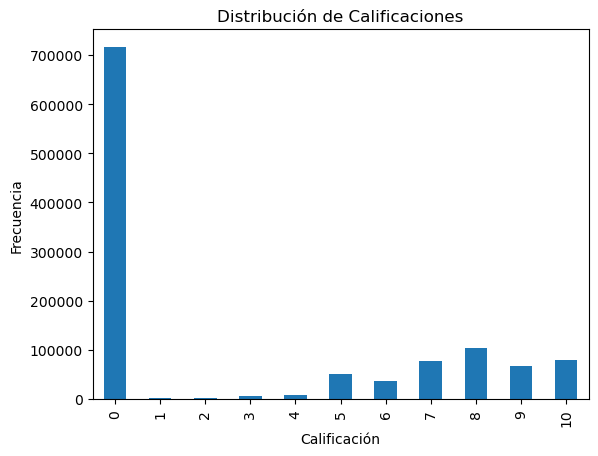

In [9]:
calificaciones['Book-Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de Calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.show()

## Análisis Exploratorio de Datos (EDA) en el dataset calificaciones:

## 1. Distribución de Calificaciones

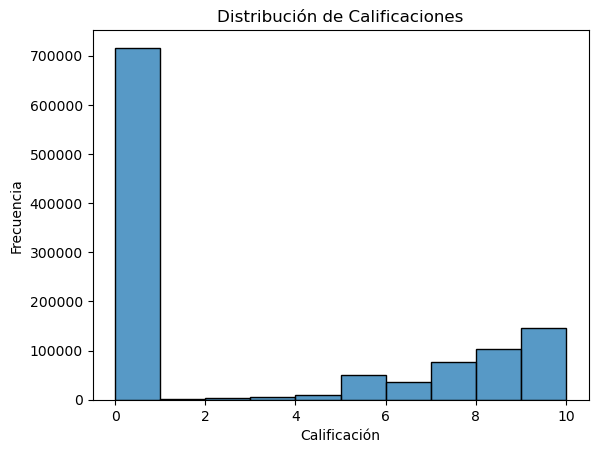

In [10]:
# Histograma de la distribución de calificaciones
sns.histplot(calificaciones['Book-Rating'], kde=False, bins=10)
plt.title('Distribución de Calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.show()

## 2. Calificaciones por Usuario

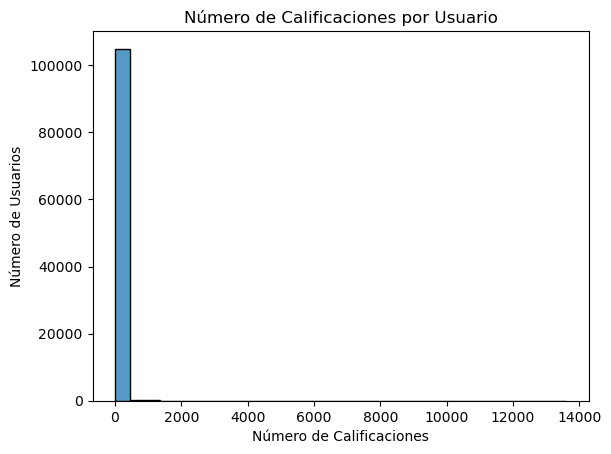

count    105283.000000
mean         10.920851
std          90.562825
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max       13602.000000
Name: count, dtype: float64


In [11]:
# Conteo de calificaciones por usuario
calificaciones_por_usuario = calificaciones['User-ID'].value_counts()

# Histograma de calificaciones por usuario
sns.histplot(calificaciones_por_usuario, bins=30)
plt.title('Número de Calificaciones por Usuario')
plt.xlabel('Número de Calificaciones')
plt.ylabel('Número de Usuarios')
plt.show()

print(calificaciones_por_usuario.describe())

## 3. Libros más y menos Calificados

In [12]:
# Conteo de calificaciones por libro
calificaciones_por_libro = calificaciones['ISBN'].value_counts()

# Libros más calificados
libros_mas_calificados = calificaciones_por_libro.head(10)
print("Libros más calificados:")
print(libros_mas_calificados)

# Libros menos calificados
libros_menos_calificados = calificaciones_por_libro.tail(10)
print("\nLibros menos calificados:")
print(libros_menos_calificados)

Libros más calificados:
ISBN
0971880107    2502
0316666343    1295
0385504209     883
0060928336     732
0312195516     723
044023722X     647
0679781587     639
0142001740     615
067976402X     614
0671027360     586
Name: count, dtype: int64

Libros menos calificados:
ISBN
1565078942     1
1566396204     1
1566472067     1
1568490992     1
1568651198     1
1568656386     1
1568656408     1
1569551553     1
1570081808     1
05162443314    1
Name: count, dtype: int64


## Análisis Exploratorio de Datos (EDA) en el dataset usuarios:

## 1. Distribución de Edades

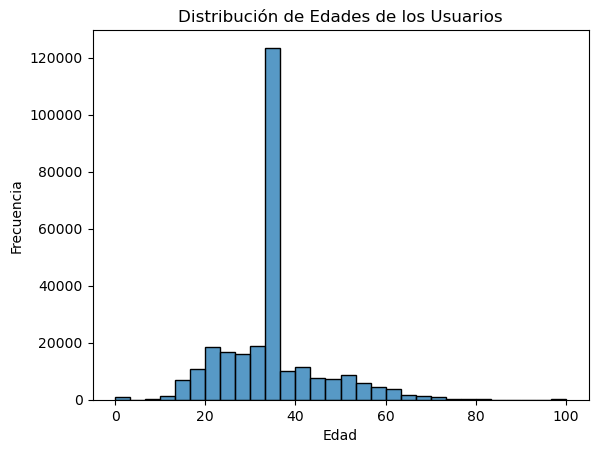

In [13]:
# Histograma de la distribución de edades
sns.histplot(usuarios['Age'], bins=30)
plt.title('Distribución de Edades de los Usuarios')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

## 2. Análisis de Ubicación

In [14]:
# Separar 'Location' en ciudad, estado y país
usuarios[['Ciudad', 'Estado', 'Pais']] = usuarios['Location'].str.split(',', expand=True, n=2)

# Análisis de la distribución de los usuarios por país
print(usuarios['Pais'].value_counts().head(10))

Pais
 usa               139183
 canada             21556
 united kingdom     18286
 germany            17021
 spain              13088
 australia          11719
 italy              11238
                     4561
 france              3440
 portugal            3305
Name: count, dtype: int64


## 3. Combinación de Datasets

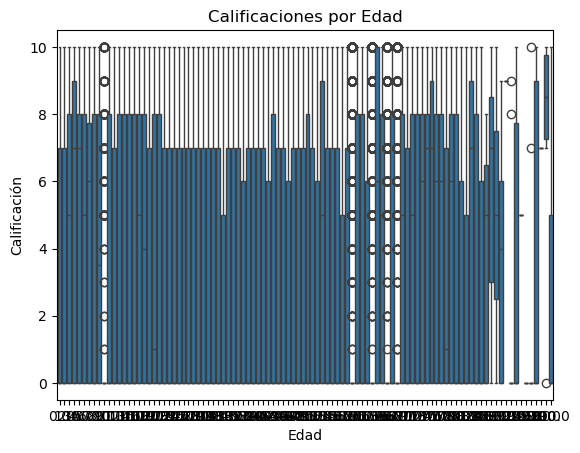

Age-Group
26-35     161529
36-45      32690
19-25      32004
46-55      23152
56-65      12493
0-18       12310
66-75       3596
76-85        615
86-100        96
Name: count, dtype: int64


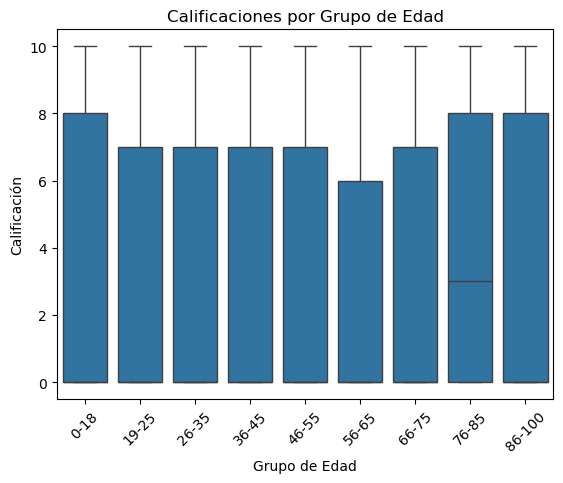

In [15]:
# Combinar datasets
usuarios_calificaciones = pd.merge(usuarios, calificaciones, on='User-ID')

# Análisis de calificaciones por edad
sns.boxplot(x='Age', y='Book-Rating', data=usuarios_calificaciones)
plt.title('Calificaciones por Edad')
plt.xlabel('Edad')
plt.ylabel('Calificación')
plt.show()

# Definir rangos de edad
bins = [0, 18, 25, 35, 45, 55, 65, 75, 85, 100]
labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '86-100']

# Crear una nueva columna 'Age-Group'
usuarios['Age-Group'] = pd.cut(usuarios['Age'], bins=bins, labels=labels, right=False)

# Verificar cómo quedaron distribuidas las edades
print(usuarios['Age-Group'].value_counts())

# Combinar con el DataFrame de calificaciones
usuarios_calificaciones = pd.merge(usuarios, calificaciones, on='User-ID')

# Visualización de calificaciones por grupo de edad
sns.boxplot(x='Age-Group', y='Book-Rating', data=usuarios_calificaciones)
plt.title('Calificaciones por Grupo de Edad')
plt.xlabel('Grupo de Edad')
plt.ylabel('Calificación')
plt.xticks(rotation=45)
plt.show()

## Visualizaciones combinadas, primero combinamos los datasets de libros y calificaciones, y luego usuarios y calificaciones. 

## 1. Calificaciones Promedio por Año
Primero combina los datasets libros y calificaciones y luego calcula la calificación promedio por año de publicación.

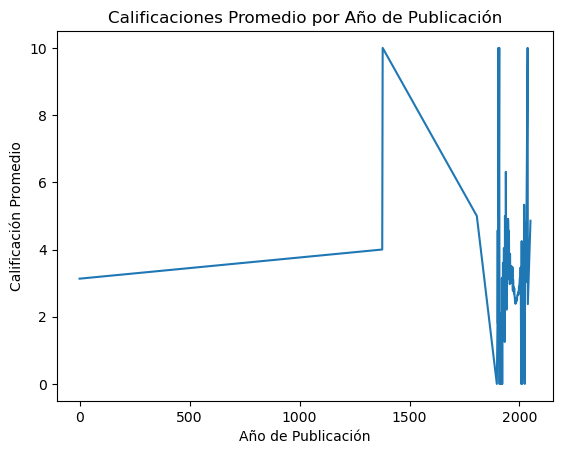

In [16]:
# Combinar libros y calificaciones
libros_calificaciones = pd.merge(libros, calificaciones, on='ISBN')

# Calcular la calificación promedio por año
calificaciones_promedio_por_año = libros_calificaciones.groupby('Year-Of-Publication')['Book-Rating'].mean()

# Visualización
calificaciones_promedio_por_año.plot(kind='line')
plt.title('Calificaciones Promedio por Año de Publicación')
plt.xlabel('Año de Publicación')
plt.ylabel('Calificación Promedio')
plt.show()

## 2. Relación entre Edad de Usuarios y Calificaciones
Para analizar la relación entre la edad de los usuarios y las calificaciones que dan, primero combinamos usuarios y calificaciones, y luego realizamos una visualización.

In [ ]:
# Combinar usuarios y calificaciones
usuarios_calificaciones = pd.merge(usuarios, calificaciones, on='User-ID')

# Visualización de la relación entre edad y calificaciones
sns.scatterplot(x='Age', y='Book-Rating', data=usuarios_calificaciones)
plt.title('Relación entre Edad de Usuarios y Calificaciones')
plt.xlabel('Edad')
plt.ylabel('Calificación')
plt.show()

## Limpieza y preparación final de tus datos

## 1. Revisión de Valores Nulos
Primero, revisamos los valores nulos en todas las columnas de los DataFrames y luego decidimos cómo manejarlos.

In [ ]:
# Revisar valores nulos en 'libros'
print("Valores nulos en 'libros':\n", libros.isnull().sum())

# Revisar valores nulos en 'calificaciones'
print("\nValores nulos en 'calificaciones':\n", calificaciones.isnull().sum())

# Revisar valores nulos en 'usuarios'
print("\nValores nulos en 'usuarios':\n", usuarios.isnull().sum())

# Rellenar valores nulos en 'usuarios' para 'Age' con la mediana
usuarios['Age'].fillna(usuarios['Age'].median(), inplace=True)

## 2. Consistencia de Datos
Nos aseguramos de que todos los datos son consistentes, especialmente en cuanto a formato de texto.

In [ ]:
# Convertir a mayúsculas o minúsculas para consistencia
libros['Book-Title'] = libros['Book-Title'].str.upper()
libros['Book-Author'] = libros['Book-Author'].str.upper()
usuarios['Ciudad'] = usuarios['Ciudad'].str.upper()
usuarios['Estado'] = usuarios['Estado'].str.upper()
usuarios['Pais'] = usuarios['Pais'].str.upper()

## 3. Verificación de ISBN
Utilizamos isbnlib para validar los números ISBN en tu dataset.

In [ ]:
# Función para verificar si un ISBN es válido
def es_isbn_valido(isbn):
    return isbnlib.is_isbn10(isbn) or isbnlib.is_isbn13(isbn)

# Calcular el número de ISBNs no válidos en 'libros'
libros_isbn_invalidos = libros[~libros['ISBN'].apply(es_isbn_valido)]
print("Número de ISBNs no válidos en 'libros':", len(libros_isbn_invalidos))

# Calcular el número de ISBNs no válidos en 'calificaciones'
calificaciones_isbn_invalidos = calificaciones[~calificaciones['ISBN'].apply(es_isbn_valido)]
print("Número de ISBNs no válidos en 'calificaciones':", len(calificaciones_isbn_invalidos))

# Mostrar algunos ejemplos de ISBNs no válidos
print("\nEjemplos de ISBNs no válidos en 'libros':")
print(libros_isbn_invalidos['ISBN'].head())

print("\nEjemplos de ISBNs no válidos en 'calificaciones':")
print(calificaciones_isbn_invalidos['ISBN'].head())

## Dividimos el dataset de calificaciones en conjuntos de entrenamiento y prueba, y luego unimos estos subconjuntos con los datasets de usuarios y libros. Esto garantizará que todos los libros y usuarios, independientemente de si han sido calificados o no, estén presentes en ambos conjuntos de entrenamiento y prueba.

## Paso 1: Dividir el Dataset de Calificaciones

In [ ]:
train_calificaciones, test_calificaciones = train_test_split(calificaciones, test_size=0.25, random_state=42)

## 2: Unir con Usuarios y Libros
Unimos los subconjuntos de calificaciones con los datasets completos de usuarios y libros para asegurarte de que todos los usuarios y libros estén representados.

In [ ]:
# Unir con el dataset de usuarios
train_usuarios_calificaciones = train_calificaciones.merge(usuarios, on='User-ID', how='outer')
test_usuarios_calificaciones = test_calificaciones.merge(usuarios, on='User-ID', how='outer')

# Unir con el dataset de libros
train_libros_calificaciones = train_calificaciones.merge(libros, on='ISBN', how='outer')
test_libros_calificaciones = test_calificaciones.merge(libros, on='ISBN', how='outer')

## 3: Guardar los Conjuntos de Entrenamiento y Prueba
Guardamos los conjuntos de datos unidos como archivos CSV.

In [ ]:
train_usuarios_calificaciones.to_csv('train_usuarios_calificaciones.csv', index=False)
test_usuarios_calificaciones.to_csv('test_usuarios_calificaciones.csv', index=False)

train_libros_calificaciones.to_csv('train_libros_calificaciones.csv', index=False)
test_libros_calificaciones.to_csv('test_libros_calificaciones.csv', index=False)